POPS_T298K
POPE_310K
POPC_T303K
POPS_T298K
POPG_T298K


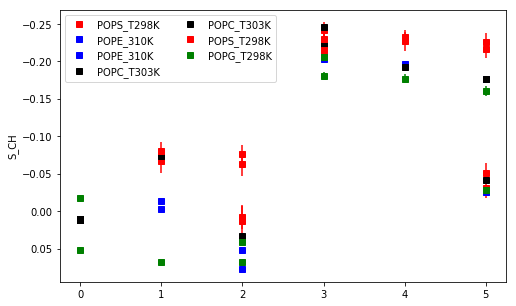

In [18]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt

colors = {'POPC' :'black','POPS':'red','POPE':'blue','POPG':'green'}
#lipids = {'POPC','POPS','POPE','POPG'}
lipids = {'POPE','POPG','POPS','POPC'}

fig= plt.figure(figsize=(8,5))
for subdir, dirs, files in os.walk(r'/home/samuli/work/NMRlipids/NMRlipidsIVPEandPG/Data/Simulations/'):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith(".md"):
            dict = eval(open(filepath).read())
            for lipid in lipids:
                if lipid in dict.get('SYSTEM'):
                    OPfilepath = subdir + '/OrderParameters.json'
                    print (dict.get('SYSTEM'))
                    with open(OPfilepath) as json_file:
                        data = json.load(json_file)
                    for key,value in data.items():
                        #print (key,value[0][0],value[0][2])
                        plt.gca().invert_yaxis()
                        plt.ylabel('S_CH')
                        if 'gamma' in key:
                            plt.plot(0,value[0][0],"s",color=colors[lipid])
                            plt.errorbar(0,value[0][0],yerr=value[0][2],color=colors[lipid])
                        if 'beta' in key:
                            plt.plot(1,value[0][0],"s",color=colors[lipid],label=dict.get('SYSTEM'))
                            plt.errorbar(1,value[0][0],yerr=value[0][2],color=colors[lipid])
                        if 'alpha' in key:
                            plt.plot(2,value[0][0],"s",color=colors[lipid])
                            plt.errorbar(2,value[0][0],yerr=value[0][2],color=colors[lipid])
                        if 'g3' in key:
                            plt.plot(3,value[0][0],"s",color=colors[lipid])
                            plt.errorbar(3,value[0][0],yerr=value[0][2],color=colors[lipid])
                        if 'g2' in key:
                            plt.plot(4,value[0][0],"s",color=colors[lipid])
                            plt.errorbar(4,value[0][0],yerr=value[0][2],color=colors[lipid])
                        if 'g1' in key:
                            plt.plot(5,value[0][0],"s",color=colors[lipid])
                            plt.errorbar(5,value[0][0],yerr=value[0][2],color=colors[lipid])
plt.legend(loc='best',ncol=2)
plt.savefig('/home/samuli/work/NMRlipids/NMRlipidsIVPEandPG/Figs/CHARMMfromLIPIDS.eps')
                    